# TASK table from File

## Test Description:
This script will test the Task table play capability of proteus.In this test we create and download a segments and play the segments using Task table which is called from bin file. Bin file should be in the same directory where script placed.Different tasks are played with CPU trigger.

This scripts supports connection via PXI only.

## Test Equipment
1. Tabor Proteus 9484M
2. Keysight Oscilloscope MSO9254A
3. 4 SMA to BNC Cable

## Hardware Connection
    Proteus Module    --->     Oscilloscope
    Channel 1         --->      Channel 1
    Channel 2         --->      Channel 2
    Channel 3         --->      Channel 3
    Channel 4         --->      Channel 4


## Test Procedure
1. Connect all the channels of Proteus module with the concerned channel of oscilloscope.
2. Connect the oscilloscope scope with system. 
2. Run the script and observe output on scope.

Proteus release - Aurora

In [1]:
# Import required Libraries
import os
import sys
import tempfile
import webbrowser
srcpath = os.path.realpath('SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from teproteus_functions_v3 import connect
from teproteus_functions_v3 import disconnect
from teproteus_functions_v3 import set_lib_dir_path
from teproteus_functions_v3 import get_cpatured_header
from teproteus_functions_v3 import gauss_env
from teproteus_functions_v3 import iq_kernel
from teproteus_functions_v3 import pack_kernel_data
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
#matplotlib notebook
import pyvisa as visa
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import signal
import math
import pdb

In [2]:
# Connect to instrument
connection = 'LAN' #input ("Do you wish to connect via LAN/PXI/LOCAL/USB ")
if connection == 'PXI':   
    # not setting this command means DLL are taken from SYS32
    #set_lib_dir_path(r'D:\Projects\ProteusAwg_Anabelle\x64\Debug') 
    # for service connection enter instrument IP
    # for PXI DLL connection enter the module slot number with Auto=False
    # when Auto=True the lowest module will be connected
    inst=connect("2",Auto=False)
    
elif connection == 'LAN':
    proteus_addr = 'TCPIP::192.90.70.22::5025::SOCKET'
    try:
        inst = TEVisaInst(proteus_addr)
    except TEVisaInst.Error as  ex1:
        print('Couldn\'t connect to \'%s\', exiting now...' % proteus_addr)
        sys.exit()
        
elif connection == 'USB':
    proteus_addr = 'USB0::0x2A8D::0x900E::MY55490134::INSTR'
    try:
        inst = TEVisaInst(proteus_addr)
    except TEVisaInst.Error as  ex1:
        print('Couldn\'t connect to \'%s\', exiting now...' % proteus_addr)
        sys.exit()
        
elif connection == 'LOCAL':
    proteus_addr = 'TCPIP::127.0.0.1::5025::SOCKET'
    try:
        inst = TEVisaInst(proteus_addr)
    except TEVisaInst.Error as  ex1:
        print('Couldn\'t connect to \'%s\', exiting now...' % proteus_addr)
        sys.exit()
        
else:
    print("Please select the conection method first")
# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print('Connected to: ' + resp)
inst.default_paranoia_level = 2


Connected to: Tabor Electronics,P9484M,000002232771,1.238.6 --Tabor Electronics,P9484M,000002232810,1.238.6 --slot#: 2, slot#: 4, 


In [3]:
# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:
if model_name.startswith('P948'):
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 1
elif model_name.startswith('P908'):
    bpp = 1
    max_dac = 255
    wpt_type = np.uint8
    offset_factor = 1
else:
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 2
    
half_dac = max_dac / 2.0    
# Get the DAC mode (8 bits or 16 bits)

resp = inst.send_scpi_query(':SYST:INF:DAC?')
if resp == 'M0': 
    dac_mode=16 
else: dac_mode=8
   
print('DAC {0} bits'.format(dac_mode))

Model: P9484M 
DAC 16 bits


In [4]:
# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
#proteus.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':TRAC:DEL:ALL') # Delete all segments of the programmable channel's DDR.
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
# Get number of channels
num_channels = inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + num_channels)
#num_channels = int(resp)

0, no error
Number of channels: 4


In [5]:
scope_addr2=  'USB0::0x2A8D::0x900E::MY55490134::INSTR'

# connect to scope via USB
try:
    resourceManager = visa.ResourceManager()   # Create a connection (session) to the instrument
    scope = resourceManager.open_resource(scope_addr2)
except visa.Error as ex2:
        print('Couldn\'t connect to \'%s\', exiting now...' % scope_addr2)
        sys.exit()
    
    
    
## scope acquisition 
# Send *IDN? and read the response
scope.write('*RST?')
scope.write('*IDN?')
idn = scope.read()
print('*IDN? returned: %s' % idn.rstrip('\n'))

for i in range(4):
    scope.write(':CHANnel{}:DISPlay OFF'.format(i+1)) 
    scope.write(':MEASure:CLEar')


*IDN? returned: KEYSIGHT TECHNOLOGIES,MSO9254A,MY55490134,06.40.01101


In [9]:
InitialFreqSampleRate = 2500
MaximumFreqSampleRate = 2500
FreqSampleRateJump = 1000

# print( 'Internal trigger Test for sampling rate {}MHz to {}MHz in jumps of {}MHz'.format(InitialFreqSampleRate,MaximumFreqSampleRate,FreqSampleRateJump)) 
for FreqSampleRate in range (InitialFreqSampleRate,MaximumFreqSampleRate+FreqSampleRateJump,FreqSampleRateJump):
    inst.send_scpi_cmd(':FREQ:RAST {} MHz'.format(int(FreqSampleRate)))
    FreqSampleRate = int(FreqSampleRate)
    
    print('***Test begin for sampling rate {}MHz ***'.format(FreqSampleRate))
        
    if FreqSampleRate > 2500:
        channel_select = [1,3]
    else:
        channel_select = [1,2,3,4]
    
    for in_channelselect in range(len(channel_select)):
        # Select Channel & Clear it for new operation
        inst.send_scpi_cmd(':INST:CHAN {}'.format(channel_select[in_channelselect]))
        # Several initializations ..
        inst.send_scpi_cmd('*CLS; *RST')
        #proteus.send_scpi_cmd(':INST:CHAN 2')
        inst.send_scpi_cmd(':TRAC:DEL:ALL') # Delete all segments of the programmable channel's DDR.
#         resp = proteus.send_scpi_query(':SYST:ERR?')
#         print(resp)
#         scope.write(':CHANnel{}:DISPlay OFF'.format(channel_select[in_channelselect]))
#         scope.write('*CLS;:DISPlay:CGRade:LEVels ')
#         scope.write('AUTOscale')
            

        # Build sine wave on channel 1
        segnum = 1
        seglen = 1024
        ncycles1 = 2
        # cyclelen = seglen
        cyclelen = (seglen/ncycles1)
        waves = [ None for _ in range(3)]
        # sin wave:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles1, num=seglen, endpoint=False)
        y = (np.sin(x) + 1.0) * half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        waves[0] = y.astype(wpt_type)
#         plt.plot(x,y)
#         print("************* WAVEFORM*****************")
        # Download sine wave to channel 1
        for ii in range(1):
            ichan = ii
            channb = ichan + 1
            segnum = ii +1
        wav = waves[0]
#         print('Download wave to segment {} of channel {}'.format(segnum,channel_select[in_channelselect]))    
        # Select channel
        inst.send_scpi_cmd(':INST:CHAN {}'.format(channel_select[in_channelselect]))    
        # Define segment
        inst.send_scpi_cmd(':TRAC:DEF {},{}'.format(segnum, seglen))
        # Select the segment
        inst.send_scpi_cmd(':TRAC:SEL {}'.format(segnum))
    #     proteus.send_scpi_cmd(':VOLT:OFFS 0.2')
        inst.send_scpi_cmd(':VOLT 0.5')
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000    
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)        
        # Send the binary-data:
        inst.write_binary_data(':TRAC:DATA', wav)
        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{}" after writing binary values'.format(resp))
        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        # Turn on the output of the selected channel:
        inst.send_scpi_cmd(':OUTP ON')    
        resp = inst.send_scpi_query(':SYST:ERR?')
#         print(resp)
#         print()
        
        
        
        # Build square wave on channel 1
        segnum = 2
        seglen = 1024
        ncycles2 =3
        # cyclelen = seglen
        #ncycles = (seglen / cyclelen)*3
        cyclelen =seglen/ncycles2
        waves = [ None for _ in range(3)]
        # square wave:
        x = np.linspace(start=0, stop=seglen, num=seglen, endpoint=False)
        y = np.fmod(x, cyclelen)
        y = (y <= cyclelen / 2) * max_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        waves[0] = y.astype(wpt_type)
#         plt.plot(x,y)
#         print("************* WAVEFORM*****************")
#         # Download square wave to channel 1
#         for ii in range(1):
#             ichan = ii
#             channb = ichan + 1
#             segnum = ii +2
        wav = waves[0]
#         print('Download wave to segment {} of channel {}'.format(segnum,channel_select[in_channelselect]))    
        # Select channel
        inst.send_scpi_cmd(':INST:CHAN {}'.format(channel_select[in_channelselect]))    
        # Define segment
        inst.send_scpi_cmd(':TRAC:DEF {},{}'.format(segnum, seglen))
        # Select the segment
        inst.send_scpi_cmd(':TRAC:SEL {}'.format(segnum))
    #     proteus.send_scpi_cmd(':VOLT:OFFS 0.2')
        inst.send_scpi_cmd(':VOLT 0.5')
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000    
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)        
        # Send the binary-data:
        inst.write_binary_data(':TRAC:DATA', wav)
        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{}" after writing binary values'.format(resp))
        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        # Turn on the output of the selected channel:
        inst.send_scpi_cmd(':OUTP ON')    
        resp = inst.send_scpi_query(':SYST:ERR?')
#         print(resp)
#         print()
        
       
        
        
        # Build triangle wave on channel 1
        segnum = 3
        seglen = 1024
        ncycles3 = 4
        # cyclelen = seglen
        cyclelen = (seglen/ncycles3)
        waves = [ None for _ in range(3)]
        # triangle wave:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles3, num=seglen, endpoint=False)
        y = np.sin(x)
        y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        waves[0] = y.astype(wpt_type)
        if dac_mode == 16:
            waves[0] = y.astype(np.uint16)
        else:
            waves[0] = y.astype(np.uint8)

#         plt.plot(x,y)
#         print("************* WAVEFORM*****************")
#         # Download triangle wave to channel 1
#         for ii in range(1):
#             ichan = ii
#             channb = ichan + 1
#             segnum = ii +3
        wav = waves[0]
#         print('Download wave to segment {} of channel {}'.format(segnum,channel_select[in_channelselect]))    
        # Select channel
        inst.send_scpi_cmd(':INST:CHAN {}'.format(channel_select[in_channelselect]))    
        # Define segment
        inst.send_scpi_cmd(':TRAC:DEF {},{}'.format(segnum, seglen))
        # Select the segment
        inst.send_scpi_cmd(':TRAC:SEL {}'.format(segnum))
    #     proteus.send_scpi_cmd(':VOLT:OFFS 0.2')
        inst.send_scpi_cmd(':VOLT 0.5')
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000    
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)        
        # Send the binary-data:
        inst.write_binary_data(':TRAC:DATA', wav)
        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{}" after writing binary values'.format(resp))
        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        # Turn on the output of the selected channel:
        inst.send_scpi_cmd(':OUTP ON')    
        resp = inst.send_scpi_query(':SYST:ERR?')
#         print(resp)
#         print()
        
    
        
        
               
        scope.write(':CHANnel{}:DISPlay ON'.format(channel_select[in_channelselect]))
        
        inst.send_scpi_cmd(':INST:CHAN {}'.format(channel_select[in_channelselect]))
        inst.send_scpi_cmd(':INIT:CONT OFF')
        inst.send_scpi_cmd(':TRIG:SOUR:ENAB CPU')
        inst.send_scpi_cmd(':TRIG:STAT ON')
        
        ######### import TASK table from a file ##############################
        # The default directory is: 'C:\Users\<user-name>\Documents\ProteusFiles'
        task_table_path = 'Tasktable.bin'

        # Alternatively use absolute path:
        mypath = os.path.realpath('.')
        task_table_path = os.path.join(mypath, task_table_path)
        print('task_table_path: "{0}"'.format(task_table_path))

        resp = inst.send_scpi_query(':SYST:ERR?')
        print(resp)
        
        # Convert the string to byte-array
        str_bytes = np.frombuffer(task_table_path.encode(), dtype=np.uint8)

        # Select task-table-file
        inst.write_binary_data(':TASK:FILE', str_bytes)

        # Load task table from the selected file:
        inst.send_scpi_cmd(':TASK:FILE:LOAD')

        resp = inst.send_scpi_query(':SYST:ERR?')
        print(resp)

        
        
        
        
        
        inst.send_scpi_cmd(':TASK:COMP:WRIT')
#         inst.send_scpi_cmd(':INST:CHAN 1')
        inst.send_scpi_cmd(':FUNC:MODE TASK')
        inst.send_scpi_cmd(':OUTP ON')
#         print('done')
        
        scope.write(':CHANnel{}:DISPlay ON'.format(channel_select[in_channelselect]))
#         scope.write('*CLS;:DISPlay:CGRade:LEVels ')
        scope.write(':CHANnel{}:PROBe 1.0'.format(channel_select[in_channelselect]))
        scope.write(':CHANnel{}:SCALe 200E-3'.format(channel_select[in_channelselect]))
        scope.write(':CHANnel{}:OFFSet 0.0'.format(channel_select[in_channelselect]))
        scope.write(':TIMebase:SCALe 1E-6')
        scope.write(':TRIGger:SWEep TRIGgered')
        scope.write(':TRIGger:MODE EDGE')
        scope.write(':TRIGger:EDGE:SOURce CHANnel{}'.format(channel_select[in_channelselect]))
        scope.write(':TRIGger:LEVel CHANnel{},120e-3'.format(channel_select[in_channelselect]))
        time.sleep(2)
        measu_freq = []
        peak_volt = []

        for i in range(3):
            time.sleep(3)
            inst.send_scpi_cmd('*TRG')
            time.sleep(3)
            scope.write(':MEASure:FREQuency CHANnel{}'.format(channel_select[in_channelselect]))
            scope.write(':MEASure:RESults?')
            time.sleep(1)
            result = scope.read()
            meas_freq = float(result.split(',')[2])/1e6
            print(meas_freq)
            measu_freq.append(meas_freq)
            time.sleep(3)
            scope.write(':MEASure:VPP CHANnel{}'.format(channel_select[in_channelselect]))
            time.sleep(1)
            scope.write(':MEASure:RESults?')
            result = scope.read()
            peak_peak_volt= float(result.split(',')[1])
            print(peak_peak_volt)
            peak_volt.append(peak_peak_volt)
            
       
               
        if abs(measu_freq[0]-1.95)<0.05 and abs(measu_freq[1]-2.93)<0.05 and abs(measu_freq[2]-3.91)<0.05:
            if 0.49<float(peak_volt[0])<0.58 and 0.50<float(peak_volt[1])<0.79 and 0.49<float(peak_volt[2])<0.58:
                print('\t\t-->Test  Pass for sampling rate {0}MHz for channel {1} \n'.format(FreqSampleRate,channel_select[in_channelselect]))
            else:
                print('\t\t-->Test  Fail for sampling rate {0}MHz for channel {1} due to peak value \n'.format(FreqSampleRate,channel_select[in_channelselect]))
        else:
            print('\t\t-->Test  Fail for sampling rate {0}MHz for channel {1} due to frequency \n'.format(FreqSampleRate,channel_select[in_channelselect]))
            
           
        for i in range(4):
            scope.write(':CHANnel{}:DISPlay OFF'.format(i+1)) 
            scope.write(':MEASure:CLEar')
            # Clear the display for next operation
    
    print('***Test completed for sampling rate {}MHz ***\n'.format(FreqSampleRate))
    
print('***Test Completed for all the sampling rates***')
# close proteus connection
proteus.close_instrument()
disconnect()

# Close the connection to the instrument
scope.close()
resourceManager.close()

***Test begin for sampling rate 2500MHz ***
task_table_path: "C:\Users\Proteus\Desktop\Mihir\Tasktable.bin"
0, no error
0, no error
1.947930674757
0.52964
2.932556399403
0.73533
3.8785618238260002
0.52946
		-->Test  Pass for sampling rate 2500MHz for channel 1 

task_table_path: "C:\Users\Proteus\Desktop\Mihir\Tasktable.bin"
0, no error
0, no error
1.948626794655
0.59158
2.932534019856
0.77361
3.901183670908
0.58399
		-->Test  Fail for sampling rate 2500MHz for channel 2 due to peak value 

task_table_path: "C:\Users\Proteus\Desktop\Mihir\Tasktable.bin"
0, no error
0, no error
1.948039113209
0.53884
2.932538704751
0.75706
3.897688795508
0.53749
		-->Test  Pass for sampling rate 2500MHz for channel 3 

task_table_path: "C:\Users\Proteus\Desktop\Mihir\Tasktable.bin"
0, no error
0, no error
1.949232728934
0.54437
2.932502897765
0.74863
3.885141187041
0.5377
		-->Test  Pass for sampling rate 2500MHz for channel 4 

***Test completed for sampling rate 2500MHz ***

***Test Completed for all 

NameError: name 'proteus' is not defined

In [7]:
# inst.send_scpi_cmd(':INST:CHAN 1')
# inst.send_scpi_cmd(':INIT:CONT OFF')
# inst.send_scpi_cmd(':TRIG:SOUR:ENAB CPU')
# # inst.send_scpi_cmd(':TRIG:ACTIVE:SEL CPU')
# inst.send_scpi_cmd(':TRIG:STAT ON')

In [ ]:
# Configure Task 1

In [ ]:
# tasklen = 4

# #Select channel
# inst.send_scpi_cmd(':INST:CHAN 1')
# inst.send_scpi_cmd(':TASK:COMP:LENG {0}'.format(tasklen))


# inst.send_scpi_cmd(':TASK:COMP:SEL 1')
# inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')                            # GLOBAL CPU trigger is the task enable
# inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(1))                  # play segment 5 DC
# inst.send_scpi_cmd(':TASK:COMP:IDLE DC')
# inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV 0')  # DC level while waiting to a trigger
# inst.send_scpi_cmd(':TASK:COMP:JUMP EVEN')
# inst.send_scpi_cmd(':TASK:COMP:DESTination NEXT')
# inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(2))                 # the next task is 2


# inst.send_scpi_cmd(':TASK:COMP:SEL 2')
# inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')                            # GLOBAL CPU trigger is the task enable
# inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(2))                  # play segment 5 DC
# inst.send_scpi_cmd(':TASK:COMP:IDLE DC')
# inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV 0')  # DC level while waiting to a trigger
# inst.send_scpi_cmd(':TASK:COMP:JUMP EVEN')
# inst.send_scpi_cmd(':TASK:COMP:DESTination NEXT')
# inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(3))                 # the next task is 2


# inst.send_scpi_cmd(':TASK:COMP:SEL 3')
# inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')                            # GLOBAL CPU trigger is the task enable
# inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(3))                  # play segment 5 DC
# inst.send_scpi_cmd(':TASK:COMP:IDLE DC')
# inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV 0')  # DC level while waiting to a trigger
# inst.send_scpi_cmd(':TASK:COMP:JUMP EVEN')
# inst.send_scpi_cmd(':TASK:COMP:DESTination NEXT')
# inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(1))                 # the next task is 2


# # inst.send_scpi_cmd(':TASK:COMP:SEL 2')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(2))                  # play segment 1 SQP
# # inst.send_scpi_cmd(':TASK:COMP:TYPE STARt')                          # start of sequence
# # inst.send_scpi_cmd(':TASK:COMP:SEQ 3')                               # sequence loop = FRAME_NMB
# # inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV 0')                          # DC level while waiting to a trigger
# # # inst.send_scpi_cmd(':TASK:COMP:DTRigger AWG')                         # issue a trigger to the ADC at start of segment
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(3))                 # the next task is 3



# # inst.send_scpi_cmd(':TASK:COMP:SEL 3')
# # # inst.send_scpi_cmd(':TASK:COMP:ENAB FBTrg')                          # ADC Feedback trigger
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(3))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE SEQ')                            # in sequence
# # # inst.send_scpi_cmd(':TASK:COMP:DESTination DSP')                     # Destination is NEXT1.segment is according to DSP Decision block.
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(4))                 # next1 task is 4



# # inst.send_scpi_cmd(':TASK:COMP:SEL 4')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(1))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE END')                            # end of sequence
# # inst.send_scpi_cmd(':TASK:COMP:LOOP 2')                              # task loop = 32
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(0))                 # next1 task is 5



# # Task 1 is associated with SEG 1, that generate single sine wave
# # Task 2 is associated with SEG 2, that generate single square wave
# # Task 3 is associated with SEG 3, that generate single trianle wave
# # Task 4 is associated with SEG 1, that generate single sine wave with loop of 2


# # Sequence is defined as below
# # Start sequence - Task 2
# # Mid sequence - Task 3
# # End sequnece - Task 4
# # This sequence is repeated (3-1) times after regular Task order played.because sequence is 
# # already played 1 time in regular Task order. 

# # So Finally in the output,waveform be like
# # regular Task order (Sine - Square - triangle - 2sine)
# # Sequence order (Square - triangle - 2sine )


# # Key points to keep in mind while execution
# # 1. After contineous mode getting off, single cycle of sine wave should appear.
# # 2. Before execution of the TASK block, make below arrangements on oscilloscope
# #    trigger source - channel 1
# #    trigger sweep - triggered
# #    trigger level - 120mv
# # 3. make horizontal resolution to 200micro.sec before execution of Task module
# #    because if it is large then whole sequence can not be captured.
# # 4. External signal generator specifications
# #    Wave type - square
# #    Frequency - 1KHz
# #    Amplitude - 4 Vpp
# #    Offset  - 0v






# # inst.send_scpi_cmd(':TASK:COMP:SEL 5')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(2))                  # play segment 2 SQP
# # inst.send_scpi_cmd(':TASK:COMP:TYPE STARt')                          # start of sequence
# # inst.send_scpi_cmd(':TASK:COMP:SEQ {0}'.format(FRAME_NMB//4))        # sequence loop = FRAME_NMB
# # inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(task_half_dac))  # DC level while waiting to a trigger
# # inst.send_scpi_cmd(':TASK:COMP:DTRigger AWG')                         # issue a trigger to the ADC at start of segment
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(6))                 # the next task is 6



# # inst.send_scpi_cmd(':TASK:COMP:SEL 6')
# # inst.send_scpi_cmd(':TASK:COMP:ENAB FBTrg')                          # ADC Feedback trigger
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE SEQ')                            # in sequence
# # inst.send_scpi_cmd(':TASK:COMP:DESTination DSP')                     # Destination is NEXT1.segment is according to DSP Decision block.
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(7))                 # next1 task is 7



# # inst.send_scpi_cmd(':TASK:COMP:SEL 7')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE END')                            # end of sequence
# # inst.send_scpi_cmd(':TASK:COMP:LOOP 4')                              # task loop = 32
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(8))                 # next1 task is 8



# # inst.send_scpi_cmd(':TASK:COMP:SEL 8')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(3))                  # play segment 3 SQP
# # inst.send_scpi_cmd(':TASK:COMP:TYPE STARt')                          # start of sequence
# # inst.send_scpi_cmd(':TASK:COMP:SEQ {0}'.format(FRAME_NMB//4))        # sequence loop = FRAME_NMB
# # inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(task_half_dac))  # DC level while waiting to a trigger
# # inst.send_scpi_cmd(':TASK:COMP:DTRigger AWG')                         # issue a trigger to the ADC at start of segment
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(9))                 # the next task is 9



# # inst.send_scpi_cmd(':TASK:COMP:SEL 9')
# # inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')     
# # #inst.send_scpi_cmd(':TASK:COMP:ENAB FBTrg')                          # ADC Feedback trigger
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE SEQ')                            # in sequence
# # inst.send_scpi_cmd(':TASK:COMP:DESTination DSP')                     # Destination is NEXT1.segment is according to DSP Decision block.
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(10))                # next1 task is 10

# # inst.send_scpi_cmd(':TASK:COMP:SEL 10')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE END')                            # end of sequence
# # inst.send_scpi_cmd(':TASK:COMP:LOOP 4')                              # task loop = 32
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(11))                # next1 task is 11

# # inst.send_scpi_cmd(':TASK:COMP:SEL 11')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(4))                  # play segment 4 SQP
# # inst.send_scpi_cmd(':TASK:COMP:TYPE STARt')                          # start of sequence
# # inst.send_scpi_cmd(':TASK:COMP:SEQ {0}'.format(FRAME_NMB//4))        # sequence loop = FRAME_NMB
# # inst.send_scpi_cmd(':TASK:COMP:IDLE:LEV {0}'.format(task_half_dac))  # DC level while waiting to a trigger
# # inst.send_scpi_cmd(':TASK:COMP:DTRigger AWG')                         # issue a trigger to the ADC at start of segment
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(12))                # the next task is 12

# # inst.send_scpi_cmd(':TASK:COMP:SEL 12')
# # inst.send_scpi_cmd(':TASK:COMP:ENAB CPU')     
# # #inst.send_scpi_cmd(':TASK:COMP:ENAB FBTrg')                          # ADC Feedback trigger
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE SEQ')                            # in sequence
# # inst.send_scpi_cmd(':TASK:COMP:DESTination DSP')                     # Destination is NEXT1.segment is according to DSP Decision block.
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(13))                # next1 task is 13

# # inst.send_scpi_cmd(':TASK:COMP:SEL 13')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:TYPE END')                            # end of sequence
# # inst.send_scpi_cmd(':TASK:COMP:LOOP 4')                              # task loop = 32
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(14))                # next1 task is 14



# # inst.send_scpi_cmd(':TASK:COMP:SEL 14')
# # inst.send_scpi_cmd(':TASK:COMP:SEGM {0}'.format(5))                  # play segment 5 DC
# # inst.send_scpi_cmd(':TASK:COMP:NEXT1 {0}'.format(1))                 # the next task is 1
         
    
# inst.send_scpi_cmd(':TASK:COMP:WRIT')
# # print('Downloading Task table to channel {0}'.format(RDOUT_CH))

# inst.send_scpi_cmd(':INST:CHAN 1')
# inst.send_scpi_cmd(':OUTP ON')
# inst.send_scpi_cmd('FUNC:MODE TASK')
# # inst.send_scpi_cmd('FUNC:MODE TASK 1')
# # inst.send_scpi_cmd('*TRG')

# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

In [ ]:
# scope.write('*CLS;:DISPlay:CGRade:LEVels ')
# scope.write('AUTOscale')
# time.sleep(5)
# scope.write(':CHANnel1:PROBe 1.0')
# scope.write(':CHANnel1:SCALe 100E-3')
# scope.write(':CHANnel1:OFFSet 0.0')
# scope.write(':TIMebase:SCALe 400E-9')
# time.sleep(2)
# scope.write(':TRIGger:SWEep TRIGgered')
# scope.write(':TRIGger:MODE EDGE')
# scope.write(':TRIGger:EDGE:SOURce CHANnel1')
# scope.write(':TRIGger:LEVel CHANnel1,120e-3')
# time.sleep(5)


# for ii in range(3):
#     inst.send_scpi_cmd('*TRG')
# # #     time.sleep(5)
# #     scope.write(':STOP')
# #     time.sleep(5)
#     scope.write(':MEASure:FREQuency CHANnel1')
#     time.sleep(1)
#     scope.write(':MEASure:RESults?')
#     result = scope.read()
#     frequency = float(result.split(',')[2])/1e6
#     print(frequency)
#     time.sleep(5)
#     scope.write(':MEASure:VPP CHANnel1')
#     time.sleep(5)
#     scope.write(':MEASure:RESults?')
#     result = scope.read()
#     peak_peak_volt3= float(result.split(',')[1])
#     print(peak_peak_volt3)
#     time.sleep(5)
# # scope.write(':RUN')
    
    


# # scope.write(':TRIGger:SWEep SINGle')
# # time.sleep(5)
# # scope.write(':MEASure:FREQuency CHANnel1')
# # time.sleep(1)
# # scope.write(':MEASure:RESults?')
# # result = scope.read()
# # frequency = float(result.split(',')[2])/1e6
# # print(frequency)
# # time.sleep(5)
# # scope.write(':MEASure:VPP CHANnel1')
# # time.sleep(5)
# # scope.write(':MEASure:RESults?')
# # result = scope.read()
# # peak_peak_volt3= float(result.split(',')[1])
# # print(peak_peak_volt3)



In [ ]:
#disconnect  
dis = input("Press enter to disconnect")
disconnect()
print("Device is Disconnected")

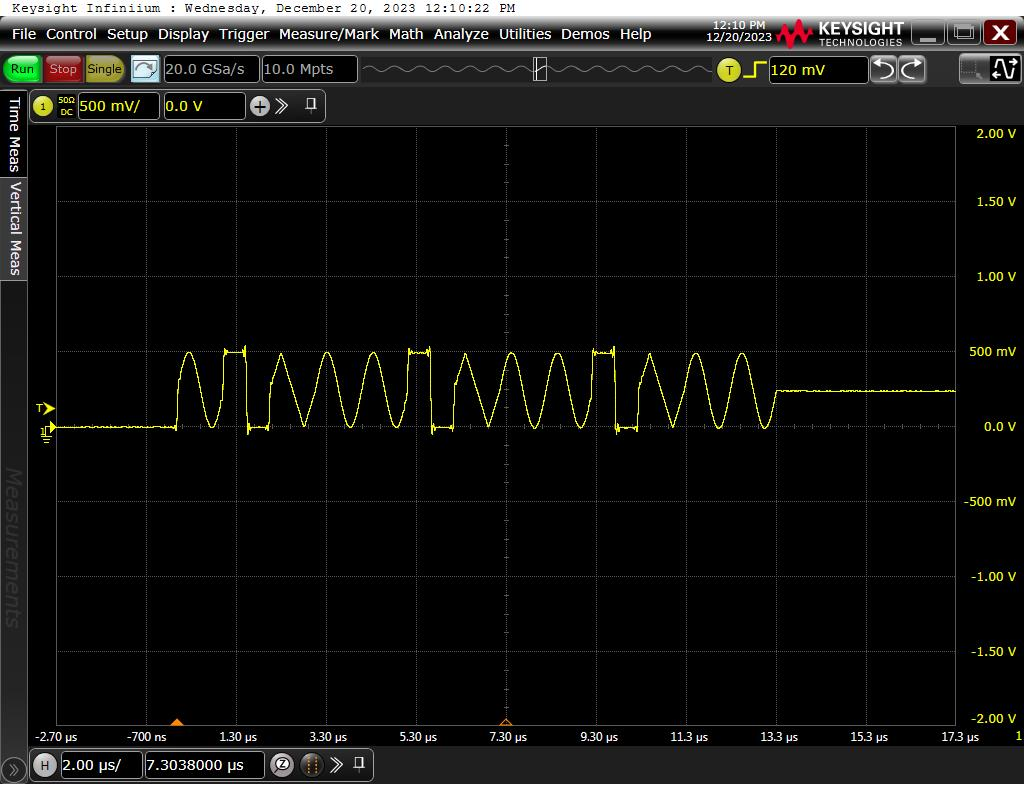